--- Setting up the environment ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.8 MB/s eta 0:00:00

Authenticating to Google Cloud...
✅ Authentication successful.

Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted.
✅ Libraries imported.
✅ All necessary classes and functions are defined.
🧠 Evaluating model from: best-model-20250919_030041_convnext_base_consolidated_cwN1-6.5.ckpt

--- Loading and splitting dataset from GCS ---
✅ Successfully fetched 2000 file paths from GCS.
Initializing dataset with 2000 files (this will take time)...
  -> [1/2000] Reading 

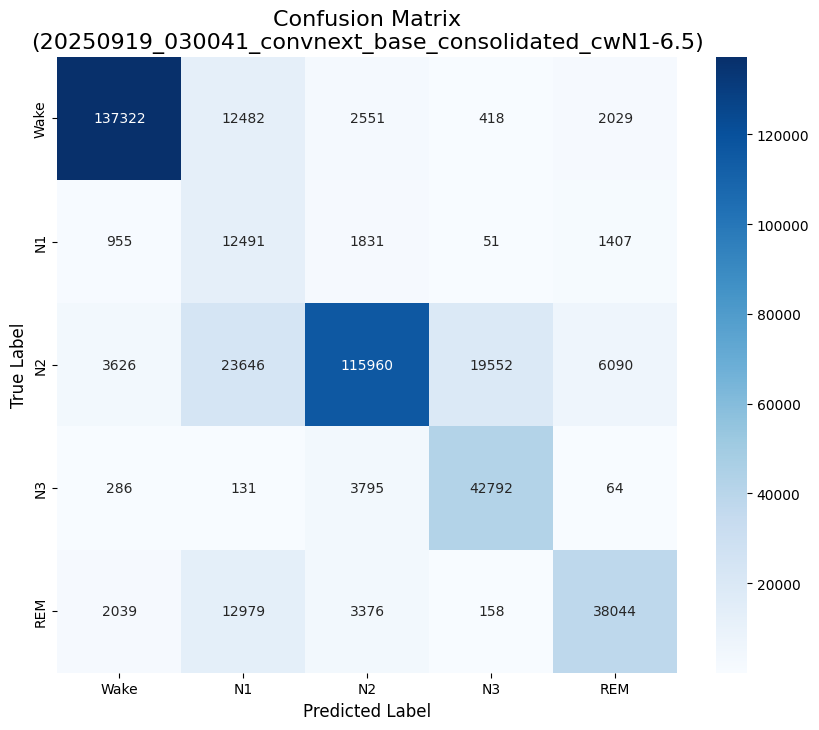

In [1]:
# ==============================================================================
# 1. SETUP: AUTHENTICATION, LIBRARIES, AND DRIVE MOUNT
# ==============================================================================
print("--- Setting up the environment ---")
from google.colab import auth
from google.colab import drive
import os

# --- Ensure dependencies are installed ---
!pip install --upgrade -q pytorch-lightning timm "pandas==2.2.2" "pyarrow==19.0.0" gcsfs "fsspec==2023.6.0" matplotlib seaborn scikit-learn

print("\nAuthenticating to Google Cloud...")
auth.authenticate_user()
print("✅ Authentication successful.")

print("\nMounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted.")


# ==============================================================================
# 2. IMPORTS AND CONFIGURATION
# ==============================================================================
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
print("✅ Libraries imported.")


# ==============================================================================
# 3. CLASS & FUNCTION DEFINITIONS (MUST MATCH TRAINING SCRIPT)
# ==============================================================================

def get_model(model_name='convnext_base', num_classes=5, pretrained=True):
    if model_name == 'convnext_base':
        model = timm.create_model('convnextv2_base.fcmae_ft_in22k_in1k', pretrained=pretrained)
        original_conv = model.stem[0]
        new_first_conv = nn.Conv2d(1, original_conv.out_channels, kernel_size=original_conv.kernel_size, stride=original_conv.stride, padding=original_conv.padding, bias=(original_conv.bias is not None))
        with torch.no_grad():
            if original_conv.weight.shape[1] == 3:
                new_first_conv.weight[:, :] = original_conv.weight.clone().mean(dim=1, keepdim=True)
        model.stem[0] = new_first_conv
        num_ftrs = model.head.fc.in_features
        model.head.fc = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model '{model_name}' not supported in this script.")
    return model

class SleepStageClassifierLightning(pl.LightningModule):
    def __init__(self, model_name='convnext_base', learning_rate=2e-5, class_weights=None, epochs=40):
        super().__init__()
        self.save_hyperparameters()
        self.model = get_model(model_name=self.hparams.model_name, num_classes=5, pretrained=False)
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float) if class_weights is not None else None)
    def forward(self, x):
        return self.model(x)

class CombinedDataset(Dataset):
    def __init__(self, file_paths_chunk):
        print(f"Initializing dataset with {len(file_paths_chunk)} files (this will take time)...")
        self.file_paths = file_paths_chunk
        self.epochs_per_file = []
        self._cache = {}

        total_files = len(self.file_paths)
        for i, f_path in enumerate(self.file_paths):
            if (i + 1) % 50 == 0 or i == total_files - 1 or i == 0:
                print(f"  -> [{i+1}/{total_files}] Reading header from: {os.path.basename(f_path)}")
            try:
                df_labels = pd.read_parquet(f_path, columns=['label'])
                num_valid = df_labels['label'].isin([0, 1, 2, 3, 4]).sum()
                self.epochs_per_file.append(num_valid)
            except Exception as e:
                print(f"  -> WARNING: Could not process {os.path.basename(f_path)}. Skipping. Error: {e}")
                self.epochs_per_file.append(0)

        self.cumulative_epochs = np.cumsum(self.epochs_per_file)
        self.total_epochs = self.cumulative_epochs[-1] if len(self.cumulative_epochs) > 0 else 0
        print(f"✅ Dataset initialized. Found a total of {self.total_epochs} valid epochs.")

    def __len__(self):
        return self.total_epochs

    def __getitem__(self, idx):
        file_idx = np.searchsorted(self.cumulative_epochs, idx, side='right')
        local_idx = idx - (self.cumulative_epochs[file_idx - 1] if file_idx > 0 else 0)
        file_path = self.file_paths[file_idx]
        if file_path not in self._cache:
            df = pd.read_parquet(file_path)
            self._cache[file_path] = df[df['label'].isin([0, 1, 2, 3, 4])].reset_index(drop=True)
        row = self._cache[file_path].iloc[local_idx]
        label = np.int64(row['label'])
        spectrogram_flat = row.drop('label').values.astype(np.float32)
        mean, std = spectrogram_flat.mean(), spectrogram_flat.std()
        spectrogram_normalized = (spectrogram_flat - mean) / (std + 1e-6)
        spectrogram_2d = spectrogram_normalized.reshape(1, 76, 60)
        return torch.from_numpy(spectrogram_2d), torch.tensor(label)

def generate_performance_report(model_checkpoint_path, dataloader, device, save_dir):
    print("\n" + "="*80)
    print("Generating Final Performance Metrics and Visualizations...")
    experiment_name = Path(model_checkpoint_path).stem.replace('best-model-', '')

    model = SleepStageClassifierLightning.load_from_checkpoint(checkpoint_path=model_checkpoint_path)
    model.to(device)
    model.eval()

    print("  -> Predicting on validation data (this may take a few minutes)...")
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            logits = model(x.to(device))
            all_preds.append(torch.argmax(logits, dim=1).cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    print("  -> Prediction complete.")

    stage_map = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
    target_names = [stage_map[i] for i in range(5)]

    print("\n--- Detailed Classification Report (Best Model) ---")
    report = classification_report(all_preds, all_labels, target_names=target_names, digits=4)
    print(report)

    print("\n--- Generating Confusion Matrix Heatmap ---")
    conf_matrix_metric = MulticlassConfusionMatrix(num_classes=5)
    matrix = conf_matrix_metric(torch.tensor(all_preds), torch.tensor(all_labels)).numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix\n({experiment_name})', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    save_path = os.path.join(save_dir, f"{experiment_name}_confusion_matrix.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Confusion matrix plot saved to: {save_path}")
    plt.show()
    print("="*80 + "\n")

print("✅ All necessary classes and functions are defined.")


# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

# --- ⚙️ USER CONFIGURATION ⚙️ ---
CHECKPOINT_PATH = "/content/drive/MyDrive/final_model_checkpoint/best-model-20250919_030041_convnext_base_consolidated_cwN1-6.5.ckpt"
GCS_SHHS1_PATH = "gs://shhs-sleepedfx-data-bucket/shhs1_processed"
GCS_SHHS2_PATH = "gs://shhs-sleepedfx-data-bucket/shhs2_processed"
NUM_FILES_PER_SET = 1000
# ---------------------------------

if not os.path.exists(CHECKPOINT_PATH):
    print(f"❌ ERROR: Checkpoint file not found at the specified path.")
    print("Please update the CHECKPOINT_PATH variable to the correct file location.")
else:
    print(f"🧠 Evaluating model from: {os.path.basename(CHECKPOINT_PATH)}")

    print("\n--- Loading and splitting dataset from GCS ---")
    shhs1_files_raw = !gsutil ls {GCS_SHHS1_PATH}/*.parquet | head -n {NUM_FILES_PER_SET}
    shhs2_files_raw = !gsutil ls {GCS_SHHS2_PATH}/*.parquet | head -n {NUM_FILES_PER_SET}

    all_raw_paths = shhs1_files_raw.nlstr.split() + shhs2_files_raw.nlstr.split()
    specific_shhs_file_paths = [path for path in all_raw_paths if path.startswith('gs://')]

    if not specific_shhs_file_paths:
        print("\n❌ ERROR: Failed to fetch file list from GCS.")
        print("Please check your GCS bucket paths, permissions, and network connection.")
    else:
        print(f"✅ Successfully fetched {len(specific_shhs_file_paths)} file paths from GCS.")
        full_dataset = CombinedDataset(specific_shhs_file_paths)

        torch.manual_seed(42)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        _, val_dataset = random_split(full_dataset, [train_size, val_size])

        val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)
        print("✅ Validation data is ready.")

        # --- MODIFICATION: Corrected the typo in torch.cuda.is_available() ---
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        drive_report_dir = "/content/drive/MyDrive/final_model_checkpoint/"
        generate_performance_report(CHECKPOINT_PATH, val_loader, device, drive_report_dir)